# McKinley Mine - SentinelHub data analysis

### Scope
- Use SentinelHub API to calculate NDVI or other band ratios for VMU's over time period

In [1]:
# Import libraries
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

from sentinelhub import SHConfig, FisRequest, BBox, Geometry, CRS, WcsRequest, CustomUrlParam, \
    DataCollection, HistogramType
from sentinelhub.time_utils import iso_to_datetime, parse_time

# Setting consistent plotting style throughout notebook
sns.set_style("white")
sns.set(font_scale=1)

# Set pandas df display options
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
# SentinelHub configuration
config = SHConfig()
config.instance_id = 'e0d91a9e-9e07-4ba3-a274-4a261d555721' # Instance ID for the Configuration
config.sh_client_id = '6b0f1254-59e8-4349-bcd3-6a56e3ea651e' # Credentials from the OAuth client
config.sh_client_secret = 'spD*%T/nPjY&/]45iXyYqEjvk_ulGn?PEHb/;};T'
config.save()

### Functions

In [21]:
def fis_data_to_dataframe(fis_data):
    """ Creates a DataFrame from list of FIS responses
    
    Parameters
    -----------
    fis_data : list
        list of data responses from FIS request

    Returns
    -----------
    output : pandas dataframe
        DF containing formatted results
    
    """
    # Setup columns in df
    columns = ['date', 'min', 'max', 'mean', 'stDev'] # Columns for band ratio result
    clm_columns = ['clm_mean'] # Columns for Cloud Mask
    snw_columns = ['snw_mean'] # Columns for snow detection
    
    # Lists to store results
    data = []
    clm_data = []
    snw_data = []
    
    
    # Loops over multipolygons?
    for fis_response in fis_data:
            
            i = 0
            # Loop over channels
            for channel, channel_stats in fis_response.items():
                
                # Results channel
                if channel == 'C0':
                    for stat in channel_stats:
                        row = [parse_time(stat['date'])]
                        for column in columns[1:]:
                            row.append(stat['basicStats'][column])
                        data.append(row)
                
                # CLM channel
                elif channel == 'C1':
                    for stat in channel_stats:
                        row = [stat['basicStats']['mean']]
                        clm_data.append(row)
                
                # SNW channel
                else: 
                    for stat in channel_stats:
                        row = [stat['basicStats']['mean']]
                        snw_data.append(row)                    
            
            # Convert the lists to df
            data_df = pd.DataFrame(data, columns=columns)
            clm_data_df = pd.DataFrame(clm_data, columns=clm_columns)
            snw_data_df = pd.DataFrame(snw_data, columns=snw_columns)
            
            # Concatenate the df 
            output_df = pd.concat([data_df, clm_data_df, snw_data_df], axis = 1)
            
    return output_df

### Import VMU vectors

In [7]:
# Open vector file
vmu_path = r"E:\McKinley\vectors\VMU_OSM_boundaries_NAD83_shifted_dissolved.shp" ## Single merged vector for all polys
vmu_polys = gpd.read_file(vmu_path)

# Reproject polys to WGS84
vmu_polys = vmu_polys.to_crs("EPSG:4326")

# Explode multipolygons to polygons to query with FIS request
vmu_polys_exploded = vmu_polys.explode()

### Loop through the VMU's and perform FIS query

In [28]:
# Create empty list to store results for all VMU's
output_list = []

# For testing only
i = 0

# Loop over VMU's
for index, row in vmu_polys_exploded.iterrows():

    # For testing only
    i = i + 1
    if i > 1:
        continue

    # Status message
    print('Now processing VMU: ' + str(row.VMU))

    # Setup parameters for FIS request
    geometry_list = Geometry(row.geometry, CRS.WGS84)
    time_interval = ('2021-01-01', '2021-04-15')
    ndvi_script = 'return [[(B08 - B04) / (B08 + B04)], CLM, SNW]'

    fis_request = FisRequest(
        data_collection=DataCollection.SENTINEL2_L2A,
        layer='BANDS-S2-L2A',
        geometry_list=[geometry_list],
        time=time_interval,
        resolution='100m',
        custom_url_params={CustomUrlParam.EVALSCRIPT: ndvi_script},
        config=config
    )

    # Run the FIS request
    fis_data = fis_request.get_data()

    # Convert the FIS result to a dataframe
    fis_df = fis_data_to_dataframe(fis_data)

    # Add the VMU to the dataframe
    fis_df['VMU'] = row.VMU

    # Append the df to the temporary list
    output_list.append(fis_df)

    # Cloud mask using CLM: https://forum.sentinel-hub.com/t/clarification-regard-the-cloud-mask-for-fis/3204/2

# Concatenate the VMU results into a single DF
fis_df_all_raw = pd.concat(output_list, axis=0)
# fis_df_all_raw

Now processing VMU: 1


In [29]:
fis_df_all_raw

,date,min,max,mean,stDev,clm_mean,snw_mean,VMU
0,2021-04-14,0.087648,0.195531,0.129442,0.025949,0.000000,0.000000,1
1,2021-04-11,0.077225,0.198546,0.109114,0.023206,0.000000,0.000000,1
2,2021-04-09,0.093789,0.214724,0.134154,0.028432,0.000000,0.000000,1
3,2021-04-06,0.081442,0.209799,0.116651,0.026154,0.000000,0.000000,1
4,2021-04-04,-0.140773,0.098665,0.003553,0.040072,1.000000,0.000000,1
5,2021-04-01,0.082338,0.198929,0.117407,0.027682,0.000000,0.000000,1
6,2021-03-30,0.084392,0.212482,0.125283,0.028290,0.000000,0.000000,1
7,2021-03-27,0.090399,0.232640,0.130056,0.032707,0.000000,0.000000,1
8,2021-03-25,0.022781,0.046238,0.036537,0.006264,1.000000,0.000000,1
9,2021-03-22,0.006283,0.276316,0.082131,0.037266,0.000000,0.000000,1


### Clean up the FIS results df

In [30]:
fis_df_all = fis_df_all_raw.copy(deep=True)

# Convert stats values from objects to float
fis_df_all['min'] = fis_df_all['min'].astype(float, errors = 'raise')
fis_df_all['max'] = fis_df_all['max'].astype(float, errors = 'raise')
fis_df_all['mean'] = fis_df_all['mean'].astype(float, errors = 'raise')
fis_df_all['stDev'] = fis_df_all['stDev'].astype(float, errors = 'raise')
fis_df_all['clm_mean'] = fis_df_all['clm_mean'].astype(float, errors = 'raise')
fis_df_all['snw_mean'] = fis_df_all['snw_mean'].astype(float, errors = 'raise')

# Drop rows with NaN
fis_df_all.dropna(inplace=True)

# Remove cloudy results
fis_df_all.drop(fis_df_all[fis_df_all['clm_mean'] > 0].index, inplace = True)

# Format the date field
fis_df_all['date'] = pd.to_datetime(fis_df_all['date'])

# Average over multipolygon VMU's
fis_df_all = fis_df_all.groupby(['date', 'VMU']).mean()

# Sort by date
fis_df_all.sort_values(['VMU','date'], inplace=True)

# Reset index
fis_df_all.reset_index(inplace=True)
fis_df_all.set_index('date', inplace=True)

fis_df_all

,VMU,min,max,mean,stDev,clm_mean,snw_mean
date,,,,,,,
2021-01-04,1,0.087844,0.318058,0.163235,0.050684,0.0,0.000000
2021-01-06,1,0.102300,0.311530,0.161251,0.046357,0.0,0.000000
2021-01-11,1,0.103587,0.319496,0.166754,0.048511,0.0,0.000000
2021-01-14,1,0.103256,0.224852,0.140785,0.027960,0.0,0.000000
2021-01-16,1,0.095226,0.300068,0.151894,0.045496,0.0,0.000000
2021-01-21,1,-0.058387,0.058237,-0.005142,0.025264,0.0,95.934426
2021-01-29,1,-0.031518,0.064479,-0.005629,0.019647,0.0,96.327869
2021-01-31,1,-0.014263,0.075277,0.011839,0.021468,0.0,94.967213
2021-02-03,1,-0.047835,0.217464,0.044446,0.063356,0.0,28.180328


In [31]:
# Print number of records
len(fis_df_all)

32

### Create plots

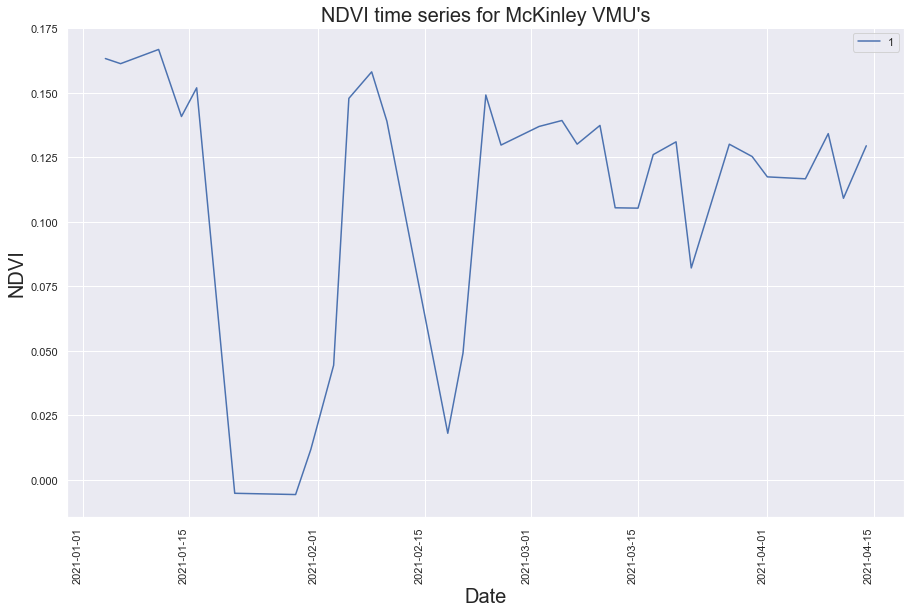

In [32]:
# Setup plot
fig, ax = plt.subplots(figsize=(15, 10))

# Build list of unique sites for legend
sites = fis_df_all.VMU.unique()

fis_df_all.reset_index().groupby('VMU').plot(x='date', y='mean', ax=ax)

# Legend and labels
plt.legend(sites)

plt.xlabel("Date", fontsize=20)
plt.ylabel("NDVI", fontsize=20)

ax.set_title(
    "NDVI time series for McKinley VMU's", fontsize=20)

plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')

plt.show()

### Export the results

In [ ]:
output_path = r"E:\McKinley\sentinelhub_output.csv"
fis_df_all.to_csv(output_path, index=True, header=True)

### Plot results

In [ ]:
# Remove 999
output_vmu_all_dates = output_vmu_all_dates[output_vmu_all_dates.VMU != 999]

# Setup plot
fig, ax = plt.subplots(figsize=(15, 15))

# Build list of unique sites for legend
sites = output_vmu_all_dates.VMU.unique()

# Convert the gdf to pd in order to plot properly
output_vmu_all_dates = pd.DataFrame(output_vmu_all_dates)

# Group the df by site for plotting purposes
output_vmu_all_dates.reset_index().groupby('VMU').plot(x='date', y='bandmath_mean', ax=ax)

# Legend and labels
plt.legend(sites)
ax.set(title="Band math results for McKinley VMU's",
       xlabel="Date",
       ylabel=bandmath_name)

plt.show()

In [ ]:
# Group the df by site for plotting purposes
#fis_df_all.reset_index().groupby('VMU').plot(x='date', y='mean', ax=ax)
# for name, group in fis_df_all.groupby('VMU'):
#     print(group['date'], group['mean'], group['VMU'])
#     plt.plot(group['date'], group['mean'], label=name)
    

# for site in sites:
#     test = fis_df_all[fis_df_all['VMU'] == site].reset_index(drop=True)
#     #print(test)
#     plt.plot(fis_df_all['date'], fis_df_all['mean'], label=site)



# f, ax1 = plt.subplots(figsize=(12, 6))
# vmu_poly.plot(ax=ax1)
# plt.show()

# [[]] will return a geodataframe not a pandas series
#vmu_poly = vmu_polys_exploded.loc[[index]]

# Convert geometry to WKT
#wkt = gpd.array.to_wkt(row)